## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Make sure to change path if you put the zip elsewhere
!unzip drive/MyDrive/chest_xray.zip

## Create dataset from directory

In [1]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

2024-04-24 11:37:55.443565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 11:37:58.277171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2024-04-24 11:38:04.868708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 11:38:05.023456: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


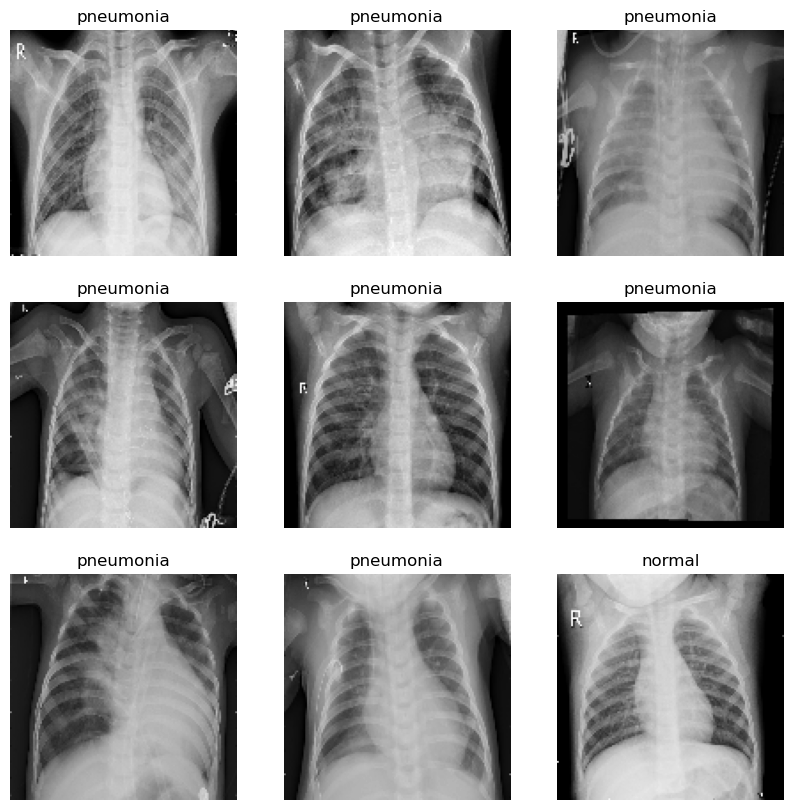

2024-04-24 11:38:12.896764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [4]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

2024-04-24 11:38:37.780402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

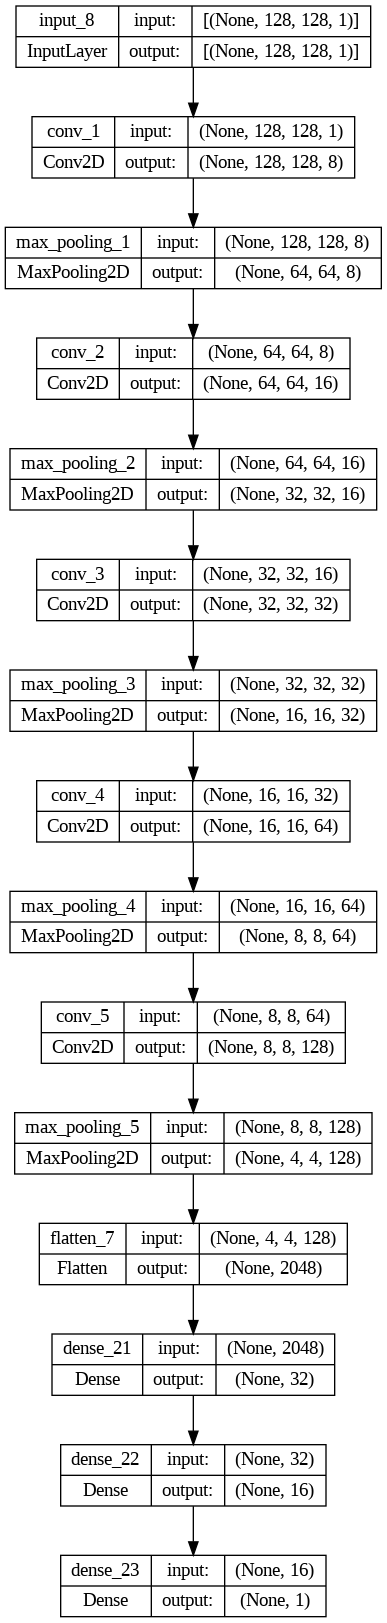

In [9]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.

cnn_output = layers.Dense(1, activation='sigmoid')(cnn_output)
cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

/home/sainane/anaconda3/envs/arn/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


AttributeError: 'Conv2D' object has no attribute 'shape'

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [ ]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights
)

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set